In [1]:
using TuringModels
gr(size=(500,500));

Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false)

ProjDir = rel_path_t("..", "scripts", "04")
cd(ProjDir)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/yF1Mq/src/Turing.jl:24


### snippet 4.43

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults and center the weight observations

In [3]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

,height,weight,age,male,weight_c
,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Extract variables for Turing model

In [4]:
y = convert(Vector{Float64}, df2[:height]);
x = convert(Vector{Float64}, df2[:weight_c]);

Define the regression model

In [5]:
@model line(y, x) = begin
    #priors
    alpha ~ Normal(178.0, 100.0)
    beta ~ Normal(0.0, 10.0)
    s ~ Uniform(0, 50)

    #model
    mu = alpha .+ beta*x
    for i in 1:length(y)
      y[i] ~ Normal(mu[i], s)
    end
end;

Draw the samples

In [6]:
samples = 2000
adapt_cycles = 1000

@time chn = sample(line(y, x), Turing.NUTS(samples, adapt_cycles, 0.65));
draws = adapt_cycles+1:samples;

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Info: [Turing] found initial ϵ: 0.10664062500000002
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Warning: Numerical error in gradients. Rejecting current proposal...
└ @ Turing.Core /Users/rob/.julia/packages/Turing/yF1Mq/src/core/ad.jl:169
┌ Warning: grad = [15.075618051181477, 27.82711910326307, NaN]
└ @ Turing.Core /Users/rob/.julia/packages/Turing/yF1Mq/src/core/ad.jl:170
┌ Info:  Adapted ϵ = 0.039897202203311326, std = [1.0, 1.0, 1.0]; 1000 iterations is used for adaption.
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/yF1Mq/src/inference/adapt/adapt.jl:90
[NUTS] Finished with
  Running time        = 205.072323423;
  #lf / sample        = 0.0;
  #evals / sample     = 22.5495;
  pre-cond. metric    = [1.0, 1.0, 1.0].
205.950420 seconds (1.48 G allocations: 97.102 GiB, 18.

Correct NUTS chain (drop adaptation samples)

In [7]:
chn2 = Chains(chn[draws,:,:], :parameters)

Object of type Chains, with data of type 1000×3×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = alpha, s, beta

parameters
        Mean     SD   Naive SE  MCSE     ESS   
alpha 154.5873 0.2958   0.0094 0.0290  104.0599
 beta   0.9073 0.0439   0.0014 0.0010 1000.0000
    s   5.1067 0.1935   0.0061 0.0043 1000.0000



Look at the proper draws (in corrected chn2)

In [8]:
describe(chn2)

Log evidence      = 0.0
Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = alpha, s, beta

Empirical Posterior Estimates
──────────────────────────────────────────────────
parameters
        Mean     SD   Naive SE  MCSE     ESS   
alpha 154.5873 0.2958   0.0094 0.0290  104.0599
 beta   0.9073 0.0439   0.0014 0.0010 1000.0000
    s   5.1067 0.1935   0.0061 0.0043 1000.0000

Quantiles
──────────────────────────────────────────────────
parameters
        2.5%     25.0%    50.0%    75.0%    97.5% 
alpha 153.5365 154.4053 154.6003 154.7662 155.3950
 beta   0.7823   0.8763   0.9070   0.9363   1.0559
    s   4.6064   4.9732   5.1005   5.2298   5.7776



Compare with a previous result

In [9]:
clip_43s_example_output = "

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
alpha 154.597086 0.27326431 0.0043206882 0.0036304132 1000
 beta   0.906380 0.04143488 0.0006551430 0.0006994720 1000
sigma   5.106643 0.19345409 0.0030587777 0.0032035103 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 154.0610000 154.4150000 154.5980000 154.7812500 155.1260000
 beta   0.8255494   0.8790695   0.9057435   0.9336445   0.9882981
sigma   4.7524368   4.9683400   5.0994450   5.2353100   5.5090128
";

Plot the chains

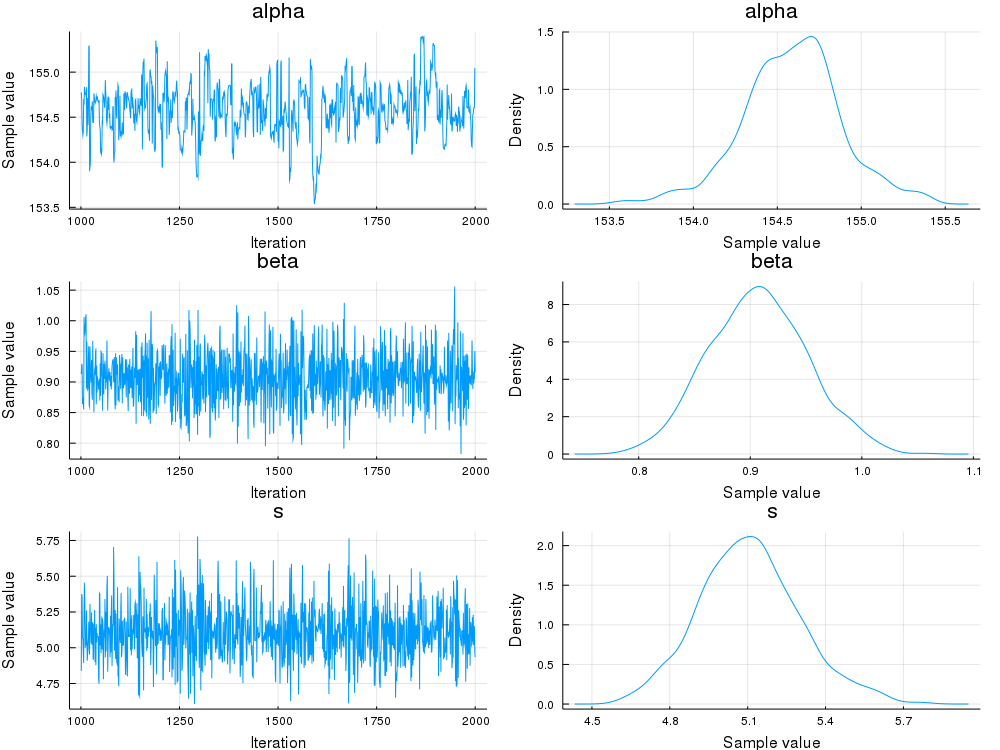

In [10]:
plot(chn2)

End of `04/m4.2t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*